In [1]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")
# Shuffle data
data = data.sample(frac=1).reset_index(drop=True)

In [2]:
data

,sent_id,text,label
0,202601-44-01,verre eksterne høyttaleren spesielt heller spi...,0
1,004745-16-03,får svar,0
2,200140-26-02,fyrer windows media player spille musikk bakgr...,0
3,302975-11-02,synd personlig deler syn asylpolitikken,0
4,200006-37-01,søvndataene generelt detaljerte,0
...,...,...,...
3321,100915-14-02,to norske barn oppi hele mona cecilie kristian...,1
3322,703572-08-01,leseren fryd se hele forløper sofia utvikler t...,1
3323,304309-06-04,invitert gjøre litt blodfattige varianter rollene,0
3324,102687-09-02,armer bein alt kameraet leker tivoli,0


<AxesSubplot:>

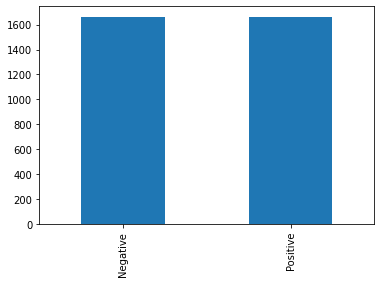

In [3]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

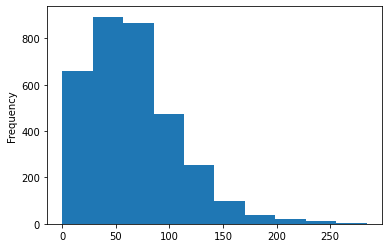

In [4]:
data["text"].str.len().plot.hist()

In [5]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=0.2, random_state=42)

print("Training set size: {}".format(train.shape))
print("Validation set size: {}".format(train.shape))

Training set size: (2660, 3)
Validation set size: (2660, 3)


In [6]:
from transformers import InputExample


def convert_data_into_input_example(data):
    input_examples = []
    for i in range(len(data)):
        example = InputExample(
            guid=data.iloc[i]['sent_id'],
            text_a=data.iloc[i]['text'],
            label=data.iloc[i]['label']
        )
        input_examples.append(example)
    return input_examples


train = convert_data_into_input_example(train)
val = convert_data_into_input_example(val)

In [7]:
from transformers import BertTokenizer, glue_convert_examples_to_features

MAX_SEQ_LENGTH = 128

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

label_list = [0, 1]

train = glue_convert_examples_to_features(examples=train, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc',
                                          label_list=label_list)
val = glue_convert_examples_to_features(examples=val, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc',
                                        label_list=label_list)

C:\Users\Mahdi\GitProjects\SENA\venv\lib\site-packages\transformers\data\processors\glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
C:\Users\Mahdi\GitProjects\SENA\venv\lib\site-packages\transformers\data\processors\glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [8]:
ex = train[0]
in_ids = ex.input_ids
decoded_sentence = tokenizer.decode(in_ids, skip_special_tokens=True)
print(decoded_sentence)

powerballader typen country duett carrie underwood grøssende fælt musikal another last goodbye


In [9]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

ResourceExhaustedError: OOM when allocating tensor with shape[119547,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:AssignVariableOp]

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.summary()

In [ ]:
import numpy as np


def my_solution(bdset):
    """ Create a list of input tensors required to be in the first argument of the
        model call function for training. e.g. `model([input_ids, attention_mask, token_type_ids])`.
    """
    input_ids, attention_mask, token_type_ids, label = [], [], [], []
    for in_ex in bdset:
        input_ids.append(in_ex.input_ids)
        attention_mask.append(in_ex.attention_mask)
        token_type_ids.append(in_ex.token_type_ids)
        label.append(in_ex.label)

    input_ids = np.vstack(input_ids)
    attention_mask = np.vstack(attention_mask)
    token_type_ids = np.vstack(token_type_ids)
    label = np.vstack(label)
    return ([input_ids, attention_mask, token_type_ids], label)


def example_to_features(input_ids, attention_masks, token_type_ids, y):
    """ Convert a training example into the Bert compatible format."""
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids}, y

In [ ]:
X_train, y_train = my_solution(train)
X_val, y_val = my_solution(val)

train = tf.data.Dataset.from_tensor_slices((X_train[0], X_train[1], X_train[2], y_train)).map(
    example_to_features).shuffle(100).batch(32)
val = tf.data.Dataset.from_tensor_slices((X_val[0], X_val[1], X_val[2], y_val)).map(example_to_features).batch(64)

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20

history = model.fit(train, validation_data=val, epochs=epochs, verbose=1, callbacks=[early_stop])

In [ ]:
from datetime import datetime

model.save(f"models/SA-BERT-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

In [ ]:
from backend.src.utils.utils import plot_history

plot_history(history)